## Neural Posterior Score Estimation (NPSE)
An introduction to score-based genreative modelling in simulation-based inference.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)


### Prior and Simulator

Uniform Prior, Gaussian Simulator in 2D.

This example allows to play with different uniform priors (centered around 0 or not, large or constrained, etc.) to see how this influences the NSE.

In [2]:
from zuko.distributions import BoxUniform
from torch.distributions.multivariate_normal import MultivariateNormal

# Prior:
bounds = {r"\theta_0": [-10, 10], r"\theta_1": [100, 250]} # not standardized !
prior = BoxUniform(
    lower=torch.tensor([b[0] for b in bounds.values()]).float(),
    upper=torch.tensor([b[1] for b in bounds.values()]).float(),
)

# Simulator
class SBIGaussian2d:
    def __init__(self, rho=0.8) -> None:
        """2d Gaussian: x ~ N(theta, rho * I).
        SBI task: infer theta from x.
        """
        self.rho = rho

    def simulator(self, theta):
        cov = torch.FloatTensor([[1, self.rho], [self.rho, 1]])
        samples_x = MultivariateNormal(loc=theta, covariance_matrix=cov).sample()
        return samples_x

    def true_posterior(self, x_obs):
        cov = torch.FloatTensor([[1, self.rho], [self.rho, 1]])
        return MultivariateNormal(loc=x_obs, covariance_matrix=cov)

simulator = SBIGaussian2d(rho=0.8).simulator
true_posterior = SBIGaussian2d(rho=0.8).true_posterior


### Posterior Estimation

#### Neural Score Estimation

In [3]:
# Training data
theta_train = prior.sample((4096,))
x_train = simulator(theta_train)

# Normalize theta
# by centering and scaling to unit variance
theta_train_ = (theta_train - theta_train.mean(dim=0)) / theta_train.std(dim=0)

# Normalize x
x_train_ = (x_train - x_train.mean(dim=0)) / x_train.std(dim=0)


# Train loader
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(theta_train_, x_train_),
    batch_size=64,
    shuffle=True,
)


In [4]:
from nse import NSE, NSELoss
from tqdm import tqdm

# Score Model
nse = NSE(theta_dim=2, x_dim=2, hidden_features=[256, 256])
loss = NSELoss(nse)

# Training parameters
n_epochs = 256
lr = 1e-3

# Optimizer
optimizer = torch.optim.Adam(nse.parameters(), lr=lr)

# Training loop
with tqdm(range(n_epochs), desc="Training epochs") as tq:
    for e in tq:
        total_loss = 0

        for batch in train_loader:
            theta, x = batch

            l = loss(theta, x)
            l.backward()

            optimizer.step()
            optimizer.zero_grad()

            total_loss += l.item()

        total_loss /= len(train_loader)
        tq.set_postfix(loss=total_loss)


Training epochs: 100%|██████████| 256/256 [02:52<00:00,  1.48it/s, loss=0.0314]


#### Sample from the approximate posterior

In [5]:
# Observed data
theta_true = torch.tensor([-5.0, 150.0])
x_obs = simulator(theta_true)
x_obs_ = (x_obs - x_train.mean(dim=0)) / x_train.std(dim=0)


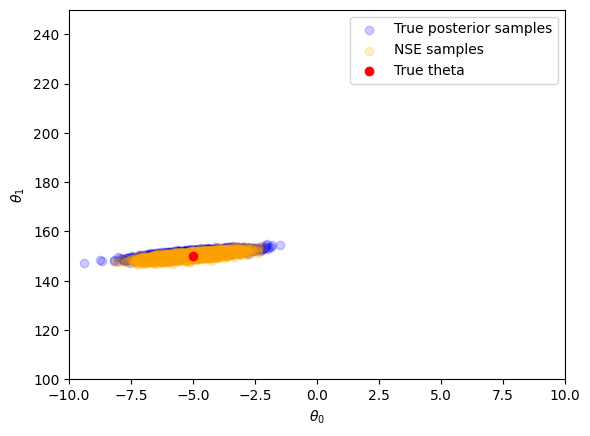

In [6]:
# Sample
# samples = nse.flow(x_obs_).sample((4096,))
samples = nse.ddim((4096,), x=x_obs_, steps=256).detach()
# samples = nse.euler((4096,), x=x_obs_, steps=256, verbose=True).detach()

# Undo normalization
samples = samples * theta_train.std(dim=0) + theta_train.mean(dim=0)

# Sample reference
samples_true = true_posterior(x_obs).sample((4096,)).numpy()

# Plot
plt.scatter(samples_true[:, 0], samples_true[:, 1], alpha=0.2, color="blue", label="True posterior samples")
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.2, color="orange", label="NSE samples")
plt.scatter(theta_true[0], theta_true[1], color="red", label="True theta")
plt.xlim(*bounds[r"\theta_0"])
plt.ylim(*bounds[r"\theta_1"])
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.legend()
plt.show()


  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:05<00:00, 75.90it/s]


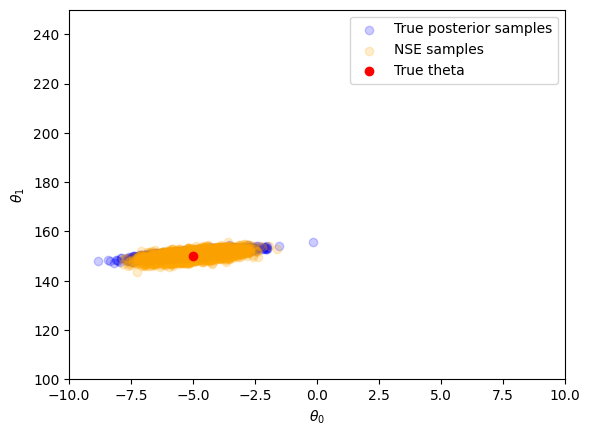

In [8]:
# Annealed Langevin Sampling
from zuko.distributions import DiagNormal
from torch import Tensor, Size


def annealed_langevin(
    nse,
    shape: Size,
    x: Tensor,
    steps: int = 64,
    lsteps: int = 1000,
    tau: float = 10,
    t_schedule="uniform",
    verbose: bool = False,
):
    if t_schedule == "uniform":
        time = torch.linspace(1, 0, steps + 1).to(x)
    elif t_schedule == "exponential":
        time = torch.linspace(0, 1, steps + 1)
        time = torch.exp(-10 * time).to(x)
    else:
        raise NotImplementedError(f"t_schedule {t_schedule} not implemented")

    theta = DiagNormal(nse.zeros, nse.ones).sample(shape)

    for t in tqdm(time[:-1], disable=not verbose):
        for _ in range(lsteps):
            z = torch.randn_like(theta)
            score = -nse(theta, x, t) / nse.sigma(t)
            # delta = tau * nse.alpha(t) / score.square().mean()
            # delta = tau * nse.alpha(t) * nse.sigma(t)**2
            delta = (
                tau * (nse.alpha(t)**.5) * 1 / (1 + score.square().mean())
            )
            theta = theta + delta * score + torch.sqrt(2 * delta) * z

    return theta


with torch.no_grad():
    # samples = annealed_langevin(
    #     nse, (4096,), x=x_obs_, steps=400, lsteps=5, tau=0.3, verbose=True
    # ).detach()
    samples = nse.predictor_corrector(
        (4096,), x=x_obs_, steps=400, verbose=True, predictor_type="id", r=0.5, n_steps=5, corrector_lda=0, eta=1
    ).detach()

# Undo normalization
samples = samples * theta_train.std(dim=0) + theta_train.mean(dim=0)

# Sample reference
samples_true = true_posterior(x_obs).sample((4096,)).numpy()

# Plot
plt.scatter(
    samples_true[:, 0],
    samples_true[:, 1],
    alpha=0.2,
    color="blue",
    label="True posterior samples",
)
plt.scatter(
    samples[:, 0], samples[:, 1], alpha=0.2, color="orange", label="NSE samples"
)
plt.scatter(theta_true[0], theta_true[1], color="red", label="True theta")
plt.xlim(*bounds[r"\theta_0"])
plt.ylim(*bounds[r"\theta_1"])
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.legend()
plt.show()
